# Survival Regression with Time-Varying Covariates

In this notebook, we use `TorchSurv` to train a model that predicts relative risk given time-varying covariates. We use the `heart` data set from the `survival` package in `R`. After training the model, we evaluate the predictive performance using evaluation metrics implemented in `TorchSurv`.

The dataset contains survival of patients on the waiting list for the Stanford heart transplant program for 103 patients. 

### 1. Dependencies

To run this notebook, dependencies must be installed. the recommended method is to use our development conda environment (**preferred**). Instruction can be found [here](https://opensource.nibr.com/torchsurv/devnotes.html#set-up-a-development-environment-via-conda) to install all optional dependencies. The other method is to install only required packages using the command line below:

In [1]:
# Install only required packages (optional)
# %pip install matplotlib
# %pip install sklearn
# %pip install pandas

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import torch
import torch.nn as nn

# PyTorch boilerplate - see https://github.com/Novartis/torchsurv/blob/main/docs/notebooks/helpers_introduction.py
from helpers_time_varying import GroupedDataset, collate_fn, expand_log_hz, expand_log_hz_survival, plot_losses
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Our package
from torchsurv.loss import cox, survival
from torchsurv.metrics.auc import Auc
from torchsurv.metrics.brier_score import BrierScore
from torchsurv.metrics.cindex import ConcordanceIndex

In [4]:
# Set seed
seed = 15
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [5]:
# Issue with eager mode
# torch._dynamo.config.suppress_errors = True  # Suppress inductor errors
# torch._dynamo.reset()  # Reset the backend

In [6]:
# Constant parameters across models
BATCH_SIZE = 32  # batch size = number of patients
EPOCHS = 100  # maximum number of epochs
LEARNING_RATE = 1e-2  # learning rate

### 2. Dataset

In datasets with time-varying covariates, each individual may contribute multiple rows of observations. This occurs because a patient can be measured repeatedly over time, with covariates updated at each measurement interval. The variables `start` and `stop` denote the time interval during which the covariates in a given row are valid, and within which the event indicator corresponds to the occurrence (or non-occurrence) of an event.

In [7]:
# Load heart dataset from R survival
df = pd.read_csv("heart.csv")
df.head(5)

,start,stop,event,age,year,surgery,transplant,id
0,0.0,50.0,1,-17.155373,0.123203,0,0,1
1,0.0,6.0,1,3.835729,0.254620,0,0,2
2,0.0,1.0,0,6.297057,0.265572,0,0,3
3,1.0,16.0,1,6.297057,0.265572,0,1,3
4,0.0,36.0,0,-7.737166,0.490075,0,0,4


The dataset contains the features: 

- `age`: age - 48 years
- `year`: year of acceptance (in years after 1 Nov 1967)
- `surgery`: prior bypass surgery 1=yes
- `transplant`: received transplant 1=yes
- `id`: patient id

Additionally, it contains our survival targets:

- `start`, `stop`, `event`: Entry time, exit time and status for this interval of time.

Further, we add two columns: `time` for the latest observation time and `event_at_time` for the event status at that time. These variables remain constant across all rows corresponding to the same patient.

In [8]:
# Add time column (max stop per id)
df["time"] = df.groupby("id")["stop"].transform("max")

# Add column for event at that time
df["event_at_time"] = df.apply(
    lambda row: df[(df["id"] == row["id"]) & (df["stop"] == row["time"])]["event"].iloc[0],
    axis=1,
)

df.head(5)

,start,stop,event,age,year,surgery,transplant,id,time,event_at_time
0,0.0,50.0,1,-17.155373,0.123203,0,0,1,50.0,1
1,0.0,6.0,1,3.835729,0.254620,0,0,2,6.0,1
2,0.0,1.0,0,6.297057,0.265572,0,0,3,16.0,1
3,1.0,16.0,1,6.297057,0.265572,0,1,3,16.0,1
4,0.0,36.0,0,-7.737166,0.490075,0,0,4,39.0,1


Next, we set up the data loaders for training, validation, and testing. Here, the `BATCH_SIZE` corresponds to the number of patient IDs per batch. We cannot sample a fixed number of rows at random as in the non time-varying covariates setting, because for each selected patient ID we must include all rows associated with that individual.

In [9]:
# Split by IDs
ids = df["id"].unique()

train_ids, test_ids = train_test_split(ids, test_size=0.3, random_state=42)
train_ids, val_ids = train_test_split(train_ids, test_size=0.3, random_state=42)

df_train = df[df.id.isin(train_ids)]
df_val = df[df.id.isin(val_ids)]
df_test = df[df.id.isin(test_ids)]

train_dataset = GroupedDataset(df_train)
val_dataset = GroupedDataset(df_val)
test_dataset = GroupedDataset(df_test)

dataloader_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

dataloader_val = DataLoader(
    val_dataset,
    batch_size=len(val_dataset),  # full batch
    shuffle=False,
    collate_fn=collate_fn,
)

dataloader_test = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, collate_fn=collate_fn)

Let $m$ be the total number of rows in the batch (the total number of observations across all individuals), and let $n$ be the number of unique IDs (where $n$ = `BATCH_SIZE`), with $m \geq n$. Further let $p$ denote the number of covariates.

The dataloader returns five outputs:
- `x`: a feature matrix of shape = (m, p)
- `event`, `time`: event indicator and event time, each of shape (n,)
- `id`, `start`: index vector of shape = (m,)

For each observation index $k$ (where $0\leq k\leq m$), the feature vector for individual `id[k]` at the observation time indicated by `start[k]` is `x[k,:]`. In plain language: `id` tells you which individual, `start` tells you which time index for that individual.


In [10]:
# Sanity check
x, (event, time), id, start = next(iter(dataloader_train))
num_features = x.size(1)

print(f"x (shape)    = {x.shape}")
print(f"num_features = {num_features}")
print(f"event        = {event.shape}")
print(f"time         = {time.shape}")
print(f"id           = {id.shape}")
print(f"start        = {start.shape}")

x (shape)    = torch.Size([54, 4])
num_features = 4
event        = torch.Size([32, 1])
time         = torch.Size([32, 1])
id           = torch.Size([54])
start        = torch.Size([54])


### 3. Cox Model

In this section, we use the [Extended Cox proportional hazards model](../_autosummary/torchsurv.loss.cox.html). Given covariates $x_{i}(t)$, a vector of size $p$, the hazard of patient $i$ has the form
$$
h_i(t) =\lambda_{0}(t)\: \lambda_i(t)
$$
The baseline hazard $\lambda_{0}(t)$ is identical across subjects (i.e., has no dependency on $i$). The subject-specific risk of event occurrence is captured through the relative hazards $\{\lambda_i(t)\}_{i = 1, \dots, N}$. 

In the traditional Cox proportional hazards model, the log-relative hazard is modeled as a linear combination of covariates:
$$
\log \lambda_i(t) = x_i(t)^\top \beta.
$$
In contrast, we allow the log-relative hazard $\log \lambda_i(t)$ to be modeled using a neural network. A key assumption in the Extended Cox model is that the model parameters are not time-varying. Consequently, we define a neural network such that
$$
\log \lambda_i(t) = f_\theta(x_i(t)),
$$
where $\theta$ represents the parameters of the neural network -- which are constant over time.  

For instance, we can train a multi-layer perceptron (MLP) to model the log-relative hazard $\log \lambda_i(t)$. 


#### 3.1. MLP model for log relative hazards

In [11]:
# Initiate Extended Cox model
cox_model = torch.nn.Sequential(
    torch.nn.BatchNorm1d(num_features),  # Batch normalization
    torch.nn.Linear(num_features, 32),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(32, 64),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(64, 1),  # Estimating log hazards for Cox models
)

#### 3.2. Model training

The function `cox.neg_partial_log_likelihood` in the time-varying covariate setting expects the matrix $\log \lambda_i(t)$ evaluated for `id` (by rows) and for `time` $t$ (by columns), resulting in an $(n, n)$ matrix.

When we pass `x` through our neural network, we obtain `log_hz_short` which produces a vector of shape $(m,)$. Each entry `log_hz_short[k]` corresponds to the value $\log \lambda_i(t) = f_\theta(x_i(t))$ for the individual $i =$`id[k]` at the time interval beginning at $t =$ `start[k]`.

To convert this vector into the required $(n, n)$ matrix format, we use the helper function `expand_log_hz`, which reformats the model output into the `log_hz` matrix expected by the loss function.

In [12]:
torch.manual_seed(42)

# Init optimizer for Cox
optimizer = torch.optim.RMSprop(cox_model.parameters(), lr=LEARNING_RATE)

# Initiate empty list to store the loss on the train and validation sets
train_losses = []
val_losses = []

# training loop
for epoch in range(EPOCHS):
    epoch_loss = torch.tensor(0.0)
    for _, batch in enumerate(dataloader_train):
        x, (event, time), id, start = batch

        optimizer.zero_grad()
        log_hz_short = cox_model(x)  # shape = (m,)

        # expand log_hz to row = id, column = time
        log_hz = expand_log_hz(id, start, time, log_hz_short)  # shape  = (n,n)

        loss = cox.neg_partial_log_likelihood(log_hz, event, time, reduction="mean")
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach()

    if epoch % (EPOCHS // 10) == 0:
        print(f"Epoch: {epoch:03}, Training loss: {epoch_loss:0.2f}")

    # Record loss on train and test sets
    train_losses.append(epoch_loss)
    with torch.no_grad():
        x, (event, time), id, start = batch = next(iter(dataloader_val))
        val_losses.append(
            cox.neg_partial_log_likelihood(
                expand_log_hz(id, start, time, cox_model(x)),
                event,
                time,
                reduction="mean",
            )
        )

Epoch: 000, Training loss: 5.63
Epoch: 010, Training loss: 5.05
Epoch: 020, Training loss: 5.03
Epoch: 030, Training loss: 5.29
Epoch: 040, Training loss: 5.03
Epoch: 050, Training loss: 5.18
Epoch: 060, Training loss: 4.99
Epoch: 070, Training loss: 4.58
Epoch: 080, Training loss: 5.06
Epoch: 090, Training loss: 4.62


We can visualize the training and validation losses.

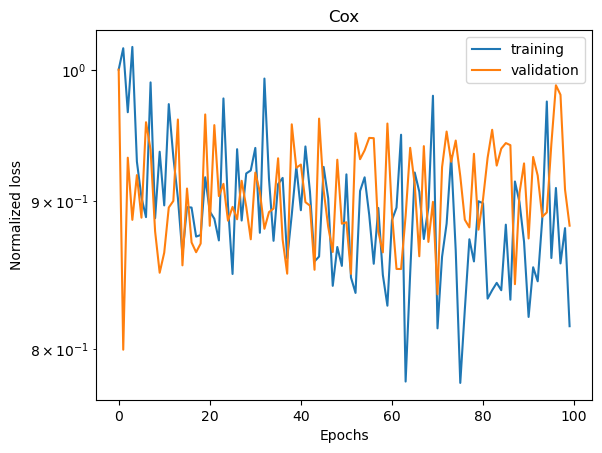

In [13]:
plot_losses(train_losses, val_losses, "Cox")

#### 3.3. Evaluation metrics

We evaluate the predictive performance of the model using 

* the [concordance index](../_autosummary/torchsurv.metrics.cindex.html) (C-index), which measures the probability that a model correctly predicts which of two comparable samples will experience an event first based on their estimated risk scores,
* the [Area Under the Receiver Operating Characteristic Curve](../_autosummary/torchsurv.metrics.auc.html) (AUC), which measures the probability that a model correctly predicts which of two comparable samples will experience an event by time t based on their estimated risk scores.
* the [Brier score](../_autosummary/torchsurv.metrics.brier_score.html), which measures the model's calibration by calculating the mean square error between the estimated survival function and the empirical (i.e., in-sample) event status.

For the Cox model, to estimate the survival function on the test set, we first need to estimate the baseline survival function on the training set:

In [14]:
cox_model.eval()
with torch.no_grad():
    x, (event, time), id, start = next(iter(dataloader_train))
    log_hz = expand_log_hz(id, start, time, cox_model(x))  # log hazard on train set
    baseline_surv = cox.baseline_survival_function(log_hz, event, time)  # baseline survival function

We then evaluate the subject-specific relative hazards and on the survival function on the test set. 

In [15]:
with torch.no_grad():
    # test event and test time of length n
    test_x, (test_event, test_time), test_id, test_start = next(iter(dataloader_test))
    test_log_hz = expand_log_hz(test_id, test_start, test_time, cox_model(test_x))  # log hazard of test set

# Compute the survival probability
test_surv = cox.survival_function_cox(baseline_surv, test_log_hz, test_time)  # shape = (n,n)

We obtain the concordance index, and its confidence interval

In [16]:
# Concordance index
cox_cindex = ConcordanceIndex()
print("Cox model performance:")
print(f"Concordance-index   = {cox_cindex(test_log_hz, test_event, test_time)}")
print(f"Confidence interval = {cox_cindex.confidence_interval()}")

Cox model performance:
Concordance-index   = 0.5597015023231506
Confidence interval = tensor([0.3282, 0.7912])


We can also test whether the observed concordance index is greater than 0.5. The statistical test is specified with H0: c-index = 0.5 and Ha: c-index > 0.5. The p-value of the statistical test is

In [17]:
# H0: cindex = 0.5, Ha: cindex > 0.5
print("p-value = {}".format(cox_cindex.p_value(alternative="greater")))

p-value = 0.30659574270248413


For time-dependent prediction (e.g., 5-year mortality), the C-index is not a proper measure. Instead, it is recommended to use the AUC. The probability to correctly predicts which of two comparable patients will experience an event by 5-year based on their estimated risk scores is the AUC evaluated at 5-year (1825 days) obtained with

In [18]:
cox_auc = Auc()

new_time = torch.tensor(1095.0)
log_hz_t = expand_log_hz(test_id, test_start, new_time.unsqueeze(0), cox_model(test_x))

# auc evaluated at new time = 1095, 3 year
print(f"AUC 3-yr             = {cox_auc(log_hz_t, test_event, test_time, new_time=new_time)}")
print(f"AUC 3-yr (conf int.) = {cox_auc.confidence_interval()}")

AUC 3-yr             = tensor([0.6364])
AUC 3-yr (conf int.) = tensor([0.4316, 0.8411])


As before, we can test whether the observed Auc at 3-year is greater than 0.5. The statistical test is specified with H0: auc = 0.5 and Ha: auc > 0.5. The p-value of the statistical test is

In [19]:
print(f"AUC (p_value) = {cox_auc.p_value(alternative='greater')}")

AUC (p_value) = tensor([0.0959])


Lastly, we can evaluate the time-dependent Brier score and the integrated Brier score

In [20]:
cox_brier_score = BrierScore()

# brier score at last 5 times
print(f"Brier score             = {cox_brier_score(test_surv, test_event, test_time)[-5:]}")
print(f"Brier score (conf int.) = {cox_brier_score.confidence_interval()[:, -5:]}")

# integrated brier score
print(f"Integrated Brier score  = {cox_brier_score.integral()}")

Brier score             = tensor([0.1891, 0.1769, 0.1529, 0.1139, 0.0846])
Brier score (conf int.) = tensor([[0.0914, 0.0809, 0.0568, 0.0262, 0.0137],
        [0.2867, 0.2728, 0.2491, 0.2016, 0.1554]])
Integrated Brier score  = 0.20158575475215912


We can test whether the time-dependent Brier score is smaller than what would be expected if the survival model was not providing accurate predictions beyond random chance. We use a bootstrap permutation test and obtain the p-value with:

In [21]:
# H0: bs = bs0, Ha: bs < bs0;
# where bs0 is the expected brier score if the survival model was not providing accurate predictions beyond random chance.

# p-value for brier score at last 5 times
print(f"Brier score (p-val) = {cox_brier_score.p_value(alternative='less')[-5:]}")

Brier score (p-val) = tensor([0.4880, 0.4930, 0.5970, 0.6200, 0.5030])


### 4. Flexible Survival Model

In this section, we use the [Flexible Survival model](../_autosummary/torchsurv.loss.survival.html). Given covariates $x_{i}(t)$, a vector of size $p$, the log hazard of patient $i$ at time $t$ is the output a neural network:

$$
\log h_i (t) = f_{\theta}(x_{i}(t), t)
$$

where $\theta$ denotes the parameters of the neural network (which may depend on time). For instance, we can train a multi-layer perceptron (MLP) to model the log hazard $\log h_i(t)$.

#### 4.1. MLP model for log hazard

In [22]:
# Same architecture than Cox model, beside inputs dimension
class SurvivalModel(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(num_features + 1, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1),  # output log-hazard for this x,t
        )

    def forward(self, x, t):
        # x: [N, F], t: [T, 1]
        N, F = x.shape
        T = t.shape[0]

        # Expand x to [N, T, F]
        x_exp = x.unsqueeze(1).expand(N, T, F)
        # Expand t to [N, T, 1]
        t_exp = t.unsqueeze(0).expand(N, T, 1)
        # Concatenate along feature dim
        xt = torch.cat([x_exp, t_exp], dim=2)  # [N, T, F+1]

        # Flatten first two dims for processing
        xt_flat = xt.reshape(N * T, F + 1)
        out_flat = self.net(xt_flat)  # [N*T, 1]

        # Reshape back to [N, T]
        out = out_flat.reshape(N, T)
        return out


# instantiate
survival_model = SurvivalModel(num_features)

#### 4.2. Model training

The Flexible Survival Model relies on a numerical approximation of the cumulative hazard in order to compute the likelihood. As a result, the log-hazard must be evaluated over a set of time points specified in `eval_time`. In practice, these evaluation times should be as uniformly distributed as possible, and they must include all observed event or censoring times stored in `time`. Further, we denote by $u$ the number of evaluation times.

Below is the code used to construct the evaluation grid:

In [23]:
# Eval time at which to evaluate the hazard
dt = 10.0
time_train = torch.tensor(df_train["time"].values, device=time.device, dtype=torch.float)
eval_time = torch.arange(0, time_train.max() + dt, dt)
extra_times = time_train.squeeze()[~torch.isin(time_train.squeeze(), eval_time)]
eval_time = torch.cat([eval_time, extra_times])  # Add original time points
eval_time = torch.unique(eval_time)  # sort and remove duplicate
eval_time = eval_time.unsqueeze(1)

The function `survival.neg_log_likelihood` for time-varying covariates expects a matrix $\log h_i(t)$ evaluated for `id` (rows) and for all `eval_time` (columns). This yields an $(n, u)$ matrix, where $u = |$`eval_time`$|$.

When we pass `x` and `eval_time` through our `survival_model`, we obtain  `log_hz_long`,  which returns a matrix of shape $(m, u)$. Each entry `log_hz_long[k, l]` corresponds to the value $\log h_i(t) = f_\theta(x_i(t), t)$ for the individual $i =$`id[k]` at the time $t =$ `eval_time[l]`.



where  
- `id[k]` identifies the individual $i$,  
- `start[k]` marks the beginning of the time interval for which the covariates $x_i(t)$ are valid, and  
- `eval_time[l]` is the evaluation time at which the hazard is computed.

To transform this $(m, u)$ output into the required $(n, u)$ format, we use the helper function `expand_log_hz_survival`, which aggregates the per-row outputs into the full `log_hz` matrix expected by the loss function.


In [24]:
torch.manual_seed(42)

# Init optimizer for Weibull
optimizer = torch.optim.Adam(survival_model.parameters(), lr=LEARNING_RATE)

# Initialize empty list to store loss on train and validation sets
train_losses = []
val_losses = []

# training loop
for epoch in range(EPOCHS):
    epoch_loss = torch.tensor(0.0)
    for _, batch in enumerate(dataloader_train):
        x, (event, time), id, start = batch
        optimizer.zero_grad()
        log_hz_long = survival_model(x, eval_time)  # shape = (m,u)

        # expand log_hz to row = id, column = time
        log_hz = expand_log_hz_survival(id, start, eval_time, log_hz_long)  # shape = (n,u)

        loss = survival.neg_log_likelihood(log_hz, event, time, reduction="mean", eval_time=eval_time)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach()

    if epoch % (EPOCHS // 10) == 0:
        print(f"Epoch: {epoch:03}, Training loss: {epoch_loss:0.2f}")

    # Record losses for the following figure
    train_losses.append(epoch_loss)
    with torch.no_grad():
        x, (event, time), id, start = next(iter(dataloader_val))
        val_losses.append(
            survival.neg_log_likelihood(
                expand_log_hz_survival(id, start, eval_time, survival_model(x, eval_time)),
                event,
                time,
                eval_time=eval_time,
                reduction="mean",
            )
        )

Epoch: 000, Training loss: 2828840448.00
Epoch: 010, Training loss: 106.96
Epoch: 020, Training loss: 114.60
Epoch: 030, Training loss: 93.06
Epoch: 040, Training loss: 93.99
Epoch: 050, Training loss: 66.67
Epoch: 060, Training loss: 13.43
Epoch: 070, Training loss: 17.53
Epoch: 080, Training loss: 12.63
Epoch: 090, Training loss: 15.12


We can visualize the training and validation losses.

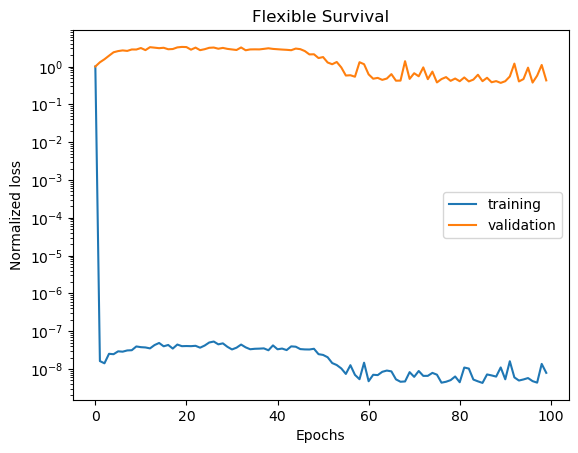

In [25]:
plot_losses(train_losses, val_losses, "Flexible Survival")

#### 4.3. Evaluation Metrics

As for the Extended Cox Model, we evaluate the predictive performance of the model using the [C-index](../_autosummary/torchsurv.metrics.cindex.html), the [AUC](../_autosummary/torchsurv.metrics.auc.html) and the [Brier score](../_autosummary/torchsurv.metrics.brier_score.html).

We begin by computing the subject-specific log-hazard at every time $t$ recorded in `time` for the test set (`test_log_hz`), as well as the log-hazard evaluated at all times in `eval_time` (`test_log_hz_eval_time`).

In [26]:
with torch.no_grad():
    # test event and test time of length n
    test_x, (test_event, test_time), test_id, test_start = next(iter(dataloader_test))
    log_hz_eval_time_long = survival_model(test_x, eval_time)
    test_log_hz_eval_time = expand_log_hz_survival(
        test_id, test_start, eval_time, log_hz_eval_time_long
    )  # shape = (n, u)
    test_log_hz = expand_log_hz_survival(test_id, test_start, test_time, log_hz_eval_time_long)  # shape = (n, n)

We then obtain the subject-specific survival at every time $t$ recorded in `time`:

In [27]:
test_surv = survival.survival_function(test_log_hz_eval_time, test_time, eval_time)  # shape = (n,n)

We can evaluate the concordance index, its confidence interval and the p-value of the statistical test testing whether the c-index is greater than 0.5:

In [28]:
# Concordance index
survival_cindex = ConcordanceIndex()
print("Cox model performance:")
print(f"Concordance-index   = {survival_cindex(test_log_hz, test_event, test_time)}")
print(f"Confidence interval = {survival_cindex.confidence_interval()}")

# H0: cindex = 0.5, Ha: cindex > 0.5
print("p-value = {}".format(survival_cindex.p_value(alternative="greater")))

Cox model performance:
Concordance-index   = 0.46268656849861145
Confidence interval = tensor([0.2420, 0.6833])
p-value = 0.6298424005508423


For time-dependent prediction (e.g., 3-year mortality), the C-index is not a proper measure. Instead, it is recommended to use the AUC. The probability to correctly predicts which of two comparable patients will experience an event by 5-year based on their estimated risk scores is the AUC evaluated at 3-year (1095 days) obtained with

In [29]:
survival_auc = Auc()

new_time = torch.tensor(1095.0)

# subject-specific log hazard at 3-yr
log_hz_t = expand_log_hz_survival(test_id, test_start, new_time.unsqueeze(0), log_hz_eval_time_long)

# auc evaluated at new time = 1095, 3 year
print(f"AUC 3-yr             = {survival_auc(log_hz_t, test_event, test_time, new_time=new_time)}")
print(f"AUC 3-yr (conf int.) = {survival_auc.confidence_interval()}")

print(f"AUC (p_value) = {survival_auc.p_value(alternative='greater')}")

AUC 3-yr             = tensor([0.3182])
AUC 3-yr (conf int.) = tensor([0.1736, 0.4628])
AUC (p_value) = tensor([0.9931])


Lastly, we can evaluate the time-dependent Brier score and the integrated Brier score

In [30]:
survival_brier_score = BrierScore()

# brier score at last 5 times
print(f"Brier score             = {survival_brier_score(test_surv, test_event, test_time)[-5:]}")
print(f"Brier score (conf int.) = {survival_brier_score.confidence_interval()[:, -5:]}")

# integrated brier score
print(f"Integrated Brier score  = {survival_brier_score.integral()}")

# H0: bs = bs0, Ha: bs < bs0;
# where bs0 is the expected brier score if the survival model was not providing accurate predictions beyond random chance.

# p-value for brier score at last 5 times
print(f"Brier score (p-val)        = {survival_brier_score.p_value(alternative='less')[-5:]}")

Brier score             = tensor([0.2193, 0.2321, 0.2039, 0.1956, 0.1854])
Brier score (conf int.) = tensor([[0.1240, 0.1361, 0.1147, 0.1056, 0.0949],
        [0.3146, 0.3281, 0.2930, 0.2856, 0.2758]])
Integrated Brier score  = 0.2334190458059311
Brier score (p-val)        = tensor([0.0270, 0.0330, 0.0160, 0.0110, 0.0070])


### 5. Models comparison

We can compare the predictive performance of the Cox proportional hazards model against the Flexible Survival model.

#### Comparing the Concordance index
The statistical test is formulated as follows, H0: cindex cox = cindex flexible survival, Ha: cindex cox > cindex flexible survival

In [31]:
print(f"Cox cindex     = {cox_cindex.cindex}")
print(f"Flexible Survival cindex = {survival_cindex.cindex}")
print(f"p-value        = {cox_cindex.compare(survival_cindex)}")

Cox cindex     = 0.5597015023231506
Flexible Survival cindex = 0.46268656849861145
p-value        = 0.21514011919498444


#### Comparing the AUC at 3-year

The statistical test is formulated as follows, H0: 3-yr auc cox = 3-yr auc flexible survival, Ha: 5-yr auc cox > 5-yr auc flexible survival

In [32]:
print(f"Cox 5-yr AUC     = {cox_auc.auc}")
print(f"Flexible Survival 5-yr AUC = {survival_auc.auc}")
print(f"p-value          = {cox_auc.compare(survival_auc)}")

Cox 5-yr AUC     = tensor([0.6364])
Flexible Survival 5-yr AUC = tensor([0.3182])
p-value          = tensor([0.0057])


#### Comparing the Brier-Score at 3-year

The statistical test is formulated as follows, H0: 3-yr bs cox = 3-yr bs flexible survival, Ha: 3-yr bs cox > 3-yr bs flexible survival

In [33]:
print(f"Cox 3-yr BS     = {cox_brier_score.brier_score[16]}")
print(f"Flexible Survival 3-yr BS = {survival_brier_score.brier_score[16]}")
print(f"p-value          = {cox_brier_score.compare(survival_brier_score)[16]}")

Cox 3-yr BS     = 0.2818903625011444
Flexible Survival 3-yr BS = 0.3131939172744751
p-value          = 0.2715027928352356
